<a href="https://colab.research.google.com/github/gmojko/fastai_learning/blob/main/Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define functions to search and download images

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')
          #L - Behaves like a list of `items` but can also index with list of indices or masks

In [4]:
from pathlib import Path
path = Path("drive/MyDrive") / "Colab Notebooks" / "FastAI/data/"

In [5]:
path.ls()

(#3) [Path('drive/MyDrive/Colab Notebooks/FastAI/data/damaged car'),Path('drive/MyDrive/Colab Notebooks/FastAI/data/car'),Path('drive/MyDrive/Colab Notebooks/FastAI/data/siema.pkl')]

Searching for 'damaged passenger car dark'


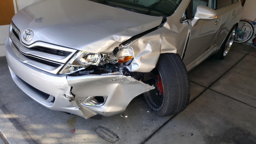

In [6]:
from fastdownload import download_url
dest = path.parent / 'crushed_car.jpg'
#dest = 'crushed_car1.jpg'
urls = search_images('damaged passenger car dark', max_images=1)
#download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
searches = 'damaged car','car'
path = Path("drive/MyDrive") / "Colab Notebooks" / "FastAI/data/"
from time import sleep

for o in searches:
    dest = (path/o)
    #dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} used green'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} usedblack'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} used white'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [8]:
#path.ls()[1].unlink()

Check if image is valid and if not delete it from folder

In [9]:
from fastai.vision.all import *
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

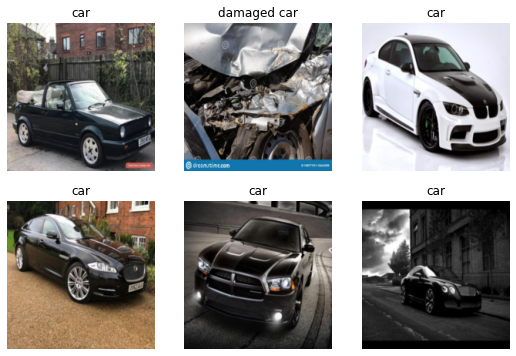

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

# alternative way is to use ImageDataLoaders:

#def is_cat(x): return x[0].isupper() #images of cats start with capital letter

# dls = ImageDataLoaders.from_name_func('.',
#    get_image_files(path), valid_pct=0.2, seed=42,
#    label_func=is_cat,
#    item_tfms=Resize(192))


dls.show_batch(max_n=6)


*   get_image_files - takes a path, and returns a list of all of the 
*   parent_label - gets the name of the folder a file is in
images in that path
* Resize(192, method='squish' - define how to transform each image before using it to train/validate, alternatively for example: Resize(128, ResizeMethod.Pad, pad_mode='zeros')


In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.917682,0.289635,0.098039,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.391313,0.236902,0.098039,00:05
1,0.288257,0.292744,0.078431,00:08
2,0.195824,0.294701,0.078431,00:08


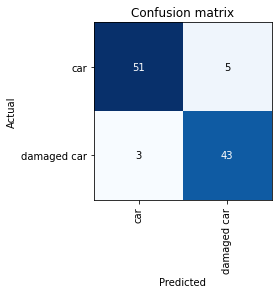

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

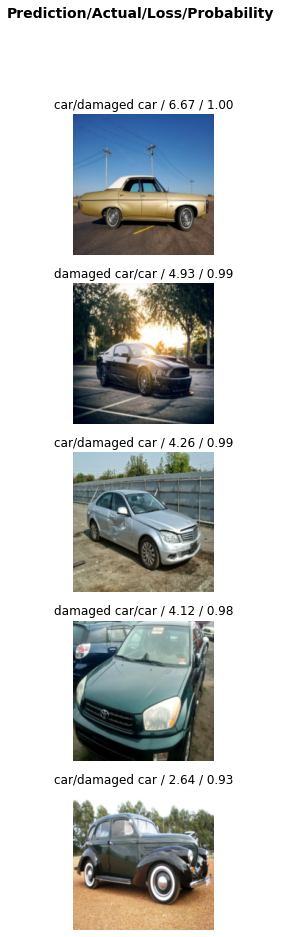

In [16]:
interp.plot_top_losses(5, nrows=5)

In [29]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

# ImageClassifierCleaner does not delete images but only label them. In order to remove them try next cell.

In [30]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Data Augmentation - batch_tfms=aug_transforms(mult=2)

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms(mult=2)    
).dataloaders(path, bs=32)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.956721,0.415914,0.117647,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.548868,0.273777,0.107843,00:05
1,0.478298,0.195830,0.088235,00:05
2,0.412292,0.167681,0.068627,00:06


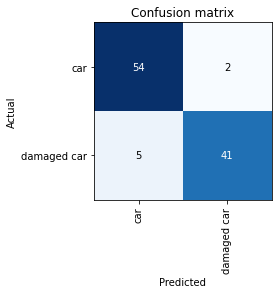

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
#interp.plot_top_losses(5, nrows=5)

Export model (learner)

In [19]:
learn.export(fname=path/'siema.pkl')
path.ls(file_exts='.pkl')

(#1) [Path('drive/MyDrive/Colab Notebooks/FastAI/data/siema.pkl')]

In [20]:
path.parent

Path('drive/MyDrive/Colab Notebooks/FastAI')

Searching for 'damaged passenger car dark'


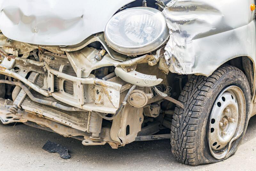

In [21]:
from fastdownload import download_url
dest = path.parent / 'crushed_car.jpg'
urls = search_images('damaged passenger car dark', max_images=1)
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [23]:
learn_inf = load_learner(path/'siema.pkl') 
pred,pred_idx,probs = learn_inf.predict(dest)
print(f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}')

Prediction: damaged car; Probability: 0.9968
